# Create STRING embeddings using [node2vec](https://snap.stanford.edu/node2vec/)

node2vec method described in

> **node2vec: Scalable Feature Learning for Networks**  
Aditya Grover, Jure Leskovec  
*Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’16* (2016) <https://doi.org/gftdzj>  
DOI: [10.1145/2939672.2939754](https://doi.org/10.1145/2939672.2939754) · PMID: [27853626](https://www.ncbi.nlm.nih.gov/pubmed/27853626) · PMCID: [PMC5108654](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108654)


In [1]:
import pathlib
import csv

import pandas as pd
import numpy as np
import scipy.sparse
import networkx as nx

from utils import get_string_dataset_path

In [2]:
# edgelist export parameters
score_threshold = 0.0
edgelist_path = "data/score-edgelists/combined-score.edgelist.tsv"

# node2vec parameters
n_dimensions = 2
raw_embeddings_path = f"data/embeddings/node2vec-{n_dimensions}d.txt"
embeddings_path = f"data/embeddings/node2vec-{n_dimensions}d.tsv.xz"

# if True, only run on a susbset of the network
development = True

## Read network and convert to edgelist format

The edgelist format is not well defined. The following resources provide some documentation:

- https://github.com/aditya-grover/node2vec/blob/master/node2vec_spark/README.md
- https://github.com/snap-stanford/snap/issues/161#issuecomment-546146427
- https://networkx.github.io/documentation/stable/reference/readwrite/edgelist.html

In [3]:
%%time
matrix = scipy.sparse.load_npz("data/score-matrices/combined_score.sparse.npz")
if development:
    n_nodes = 2000
    matrix = matrix[:n_nodes, :n_nodes] # subset matrix for development

CPU times: user 747 ms, sys: 17 ms, total: 764 ms
Wall time: 763 ms


In [4]:
def generate_nonzero_values(matrix: scipy.sparse.spmatrix, score_threshold=0.0, one_index=False):
    """
    Return an iterator of (row_index: int, col_index: int, score: int) tuples
    one_index adds 1 to row and col indices for compatability with node2vec,
    which possibility requires node ids to start at 1 for directed graphs.
    See https://github.com/snap-stanford/snap/issues/161#issuecomment-546146427
    """
    coo = matrix.tocoo()
    # take upper triangle since matrix is symmetric with a zero diagonal
    coo = scipy.sparse.triu(coo)
    print(f"{sum(coo.data >= score_threshold):,} edges above threshold")
    for row, col, score in zip(coo.row, coo.col, coo.data):
        if score < score_threshold:
            continue
        if one_index:
            row += 1
            col += 1
        yield row, col, score


def write_edgelist(edge_tuples, path):
    """
    Write edge_tuples (from generate_nonzero_values) to a .edgelist.tsv file.
    This file format is not well documented or standardized. This function
    does not write a header.
    """
    with pathlib.Path(path).open("w") as write_file:
        writer = csv.writer(write_file, delimiter="\t")
        writer.writerows(edge_tuples)

In [5]:
%%time
edge_tuples = generate_nonzero_values(matrix, score_threshold=score_threshold, one_index=False)
write_edgelist(edge_tuples, edgelist_path)

87,986 edges above threshold
CPU times: user 899 ms, sys: 16.9 ms, total: 916 ms
Wall time: 913 ms


## Run node2vec command

node2vec CLI documentation:

```
An algorithmic framework for representational learning on graphs. [Aug 29 2019]
================================================================================
Input graph path (-i:)=graph/karate.edgelist
Output graph path (-o:)=emb/karate.emb
Number of dimensions. Default is 128 (-d:)=128
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
```

For node2vec installation via snap on Linux, [see this commit](https://github.com/related-sciences/string-protein-network/commit/4d02d6ce11c792758a1ee82419e2bd6f789617a3). Note that the `node2vec` command can be "killed" when system resources are insufficient ([see issue](https://github.com/snap-stanford/snap/issues/188)).

In [6]:
# interpolate command
command = f'''
node2vec \\
  -i:{edgelist_path} \\
  -o:{raw_embeddings_path} \\
  -d:{n_dimensions} -w -v
'''.strip()
print(command)

node2vec \
  -i:data/score-edgelists/combined-score.edgelist.tsv \
  -o:data/embeddings/node2vec-2d.txt \
  -d:2 -w -v


In [7]:
# execute the command with a system call
! {command}


An algorithmic framework for representational learning on graphs. [Aug 29 2019]
Input graph path (-i:)=data/score-edgelists/combined-score.edgelist.tsv
Output graph path (-o:)=data/embeddings/node2vec-2d.txt
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=YES
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO
Read 87986 lines from data/score-edgelists/combined-score.edgelist.tsv
Preprocessing progress: 95.29% 
Walking Progress: 50.15%
Learning Progress: 93.41% 


### Tidy embeddings

Read embeddings and rewrite them in a cleaner format.
See [issue on file format](https://github.com/snap-stanford/snap/issues/192).

In [8]:
# Show the head of protein info
gene_path = get_string_dataset_path("protein.info")
gene_df = pd.read_csv(gene_path, sep='\t')
gene_df = gene_df.reset_index()
index_to_name = gene_df.set_index('index')['preferred_name'].to_dict()
gene_df.tail(2)

,index,protein_external_id,preferred_name,protein_size,annotation
19564,19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available
19565,19565,9606.ENSP00000485678,OR6Q1,317,Olfactory receptor 6Q1; Odorant receptor; Olfa...


In [9]:
embedding_df = (
    pd.read_csv(raw_embeddings_path, sep=" ", skiprows=1, index_col=0, header=None)
    .rename_axis(index="node_id")
    .add_prefix("emb_")
    .sort_index()
)
embedding_df["preferred_name"] = embedding_df.index.map(index_to_name)
embedding_df = embedding_df.set_index("preferred_name", append=True)
embedding_df.head(3)

,,emb_1,emb_2
node_id,preferred_name,,
0,ARF5,0.049139,-7.27577
1,M6PR,0.025605,-7.00591
2,FKBP4,-0.019513,-7.25800


In [10]:
len(embedding_df)

1994

In [11]:
embedding_df.to_csv(embeddings_path, sep="\t")

## Plot first 2 embeddings

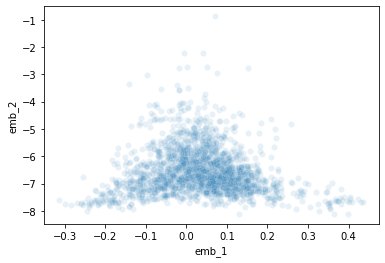

In [12]:
import seaborn
%matplotlib inline
seaborn.scatterplot("emb_1", "emb_2", data=embedding_df, alpha=0.1);